# Digital Filtering

Signal preconditioning is an important aspect of control and estimation techniques. In this notebook, we will capture raw accelerometer data and filter out noise with a single-pole [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter).

Additionally, this notebook serves as an example of how to interface with the Teensy from Python to set configuration and capture data.

In [10]:
%gui qt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time, sys
import pyqtgraph as pg

import numpy as np
np.set_printoptions(linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Low-pass Filter Basics

First, we will recall how to design a first-order low-pass filter (LPF) and write the corresponding code.

Given a signal with undesired high-frequency noise, it may be advantageous to apply an LPF to isolate the low frequency dynamics we are interested in. Alternatively, when downsampling/sampling a signal, it is important to use an antialiasing LPF. The simplest LPF is modeled after an analog RC circuit and has transfer function
$$
H(s) = \frac{\omega_c}{s + \omega_c},
$$
where $\omega_c$ is the cutoff frequency ($-3$ dB point) of the filter. In an ideal brick-wall filter, any frequency content greater than $\omega_c$ rad/s would be completely filtered out. Of course, this is not physically realizable and frequencies above $\omega_c$ will be attenuated according to a fall off of $-20$ dB/decade.

A **discrete-time realization** of this filter is required for digital implementation. It is implemented as a first-order infinite-impulse response (IIR) filter. It can be simply coded using following recurrence relation
$$
y_i = (1-\alpha)y_{i-1} + \alpha x_i,
$$
where $\alpha\in[0,1]$ is the filter parameter, $y_i$ is the filtered output and $x_i$ is a new measurement at sample $i$. Notice that a single delay element $y_{i-1}$ is required---this is due to the discrete-time LPF being a first-order IIR filter (i.e., a single pole).

The filter parameter $\alpha$ can be calculated from the desired cutoff frequency of the filter using
$$
\alpha = \frac{2\pi T_s f_c}{2\pi T_s f_c + 1},
$$
where $f_c = \omega_c\,/\,2\pi$ and $T_s = 1\,/\,F_s$ is the sampling period of the data being processed.

Alternatively, $\alpha$ can be calculated in terms of the desired time-constant $\tau$ (i.e., controlling the "speed" of the first-order LTI filter) as
$$
\alpha = \frac{T_s}{\tau + T_s}.
$$

A Python implementation of this RC LPF (sometimes called "alpha-filter") is given below.

In [11]:
class LPF:
    def __init__(self, initialize=True):
        # to be calculated using method below
        self.alpha = None
        # single delay element
        self.y = None
        # use first measurement as initial filter state
        self.initialize = initialize
    
    def apply(self, x):
        if self.alpha is None:
            raise ValueError("filter alpha not set")

        if self.y is None:
            if self.initialize:
                self.y = x
            else:
                self.y = np.zeros_like(x)
        self.y = (1-self.alpha) * self.y + self.alpha * x
        return self.y
    
    def set_fc(self, Ts, fc):
        self.alpha = (2 * np.pi * Ts * fc) / (2 * np.pi * Ts * fc + 1)
        
    def set_tau(self, Ts, tau):
        self.alpha = Ts / (tau + Ts)

## Teensy IMU Setup

The Teensy 4.0 is a powerful ARM Cortex-M7 microcontroller with [impressive performance](https://www.pjrc.com/store/teensy40.html). It is connected to an [ICM20948](https://www.adafruit.com/product/4554) inertial measurement unit (IMU), which can provide linear acceleration, angular velocities, and compass directions within the Earth's magnetic field. The Teensy is running a simple [Arduino sketch](https://github.com/plusk01/teensyimu/blob/master/firmware/firmware.ino) that samples the IMU at a specified frequency. All of these details are [abstracted away](https://github.com/plusk01/teensyimu/blob/master/src/serial_driver.cpp) and the necessary functionality is provided in Python via a serial driver. For basic interactions with the Teensy, the `teensytools` Python module can be used:

In [12]:
import teensytools as tt

## Capturing Data for Offline Processing

The simplest way to capture IMU data from the Teensy is to sample a batch of data and then post-process it. This can be done with the `capture` method, where the desired sample rate `Fs` must be specified. The sample duration is specified with the `seconds` kwarg, which defaults to 1 second. A data matrix which is `Nx7` is returned, where columns contain the following data: `time (s), acc x, acc y, acc z, gyr x, gyr y, gyr z`.

In [13]:
Fs = 1000 # Hz
data = tt.batch.capture(Fs, seconds=1)

In [14]:
print(data.shape) # cols: time (s), acc x, acc y, acc z, gyr x, gyr y, gyr z
tt.getstats(data)

(1001, 7)
Sample rate: 1000 Hz
Duration:    1.00 seconds
Mean accel:  (0.10, -1.34, 8.95)
std. accel:  (1.17, 4.47, 4.82)
Mean gyro:   (-0.24, -0.23, -0.34)
std. gyro:   (1.66, 0.71, 0.80)


We can process this batch of data offline in some algorithm or save it in a CSV file for later, like so:

In [15]:
tt.csvwrite('test.csv', data)

This data can then be loaded back into Python with:

In [16]:
data = tt.csvread('test.csv')
print(data.shape)
tt.getstats(data)

(1001, 7)
Sample rate: 1000 Hz
Duration:    1.00 seconds
Mean accel:  (0.10, -1.34, 8.95)
std. accel:  (1.17, 4.47, 4.82)
Mean gyro:   (-0.24, -0.23, -0.34)
std. gyro:   (1.66, 0.71, 0.80)


Below is an example of how to plot this raw data

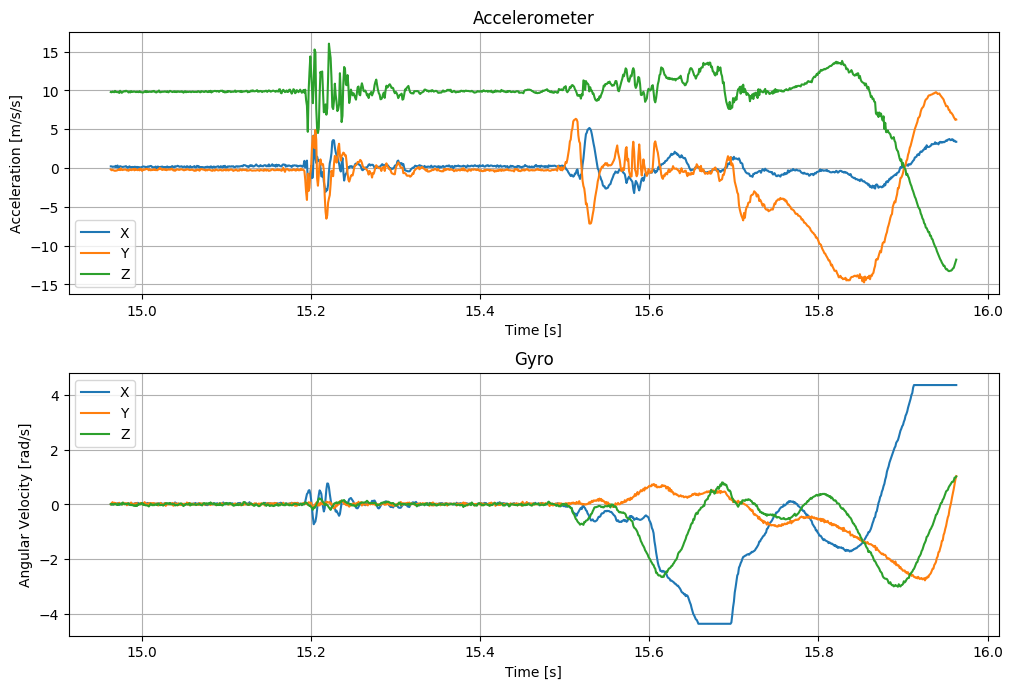

In [17]:
tt.batch.plot(data)

### Applying an Algorithm to the Data

Now that we have a batch of data, we would like to apply an algorithm to it offline.

First, we define a callback (here named `cb`) that will be used to process each sample (i.e., row) in `data`. While the name of this callback is unimportant, the argument list must be `(t, accel, gyro)`. Equally important is the `return` statement, which returns data which will be stacked in an output matrix once the algorithm is finished processing the data.

In [ ]:
lpf = LPF()
Ts = tt.getTs(data)
lpf.set_fc(Ts, 20)
def cb(t, accel, gyro):
    # since our LPF class doesn't care about the size of the data, just stack all measurements into one vector
    stacked = np.hstack((accel,gyro))
    filtered = lpf.apply(stacked)
    
    # extract the relevant elements
    accelf = filtered[0:3]
    gyrof = filtered[3:7]
    
    # return filtered outputs
    return (t, accelf, gyrof)

After coding our processing method, we can apply it to the data using the `process` helper method. The output of this method is a matrix whose rows are made up of whatever was returned in the `cb`. In this case, the format of `data` and `dataf` will be the same, except that `dataf` will have accelerometer and gyro samples that have been LPF'd.

In [ ]:
dataf = tt.batch.process(data, cb)

In [ ]:
# We can use the same plotting function since dataf has the
# same format (i.e., col ordering) of the original data matrix
tt.batch.plot(dataf)

## Capturing Data for Online Processing

Alternatively, IMU data can be processed online. This provides more immediate feedback on how the algorithm is performing.

First, we demonstrate how to plot the raw IMU data online using `tt.online.liveplot`. This method takes an argument for the IMU sample rate `Fs` as before. Additionally, it allows you to specify the plotting frequency `Fplot`. This frequency should be less than 30 Hz and decreasing it can improve performance on slower machines. Other parameters include `window_seconds`, which specifies how many seconds of data to keep in the plot window and `seconds`, which specifies how long to plot for. Note that plotting can be terminated early by simply closing the plot window.

In [4]:
Fs = 1000 # Hz
data = tt.online.liveplot(Fs, Fplot=20, window_seconds=5, seconds=10)

Note that any data that was collected during the liveplot will be returned, and any of the offline methods can be used on this data.

Sample rate: 1000 Hz
Duration:    10.54 seconds
Mean accel:  (0.23, -0.28, 9.87)
std. accel:  (0.07, 0.06, 0.06)
Mean gyro:   (0.02, 0.01, 0.00)
std. gyro:   (0.02, 0.03, 0.03)


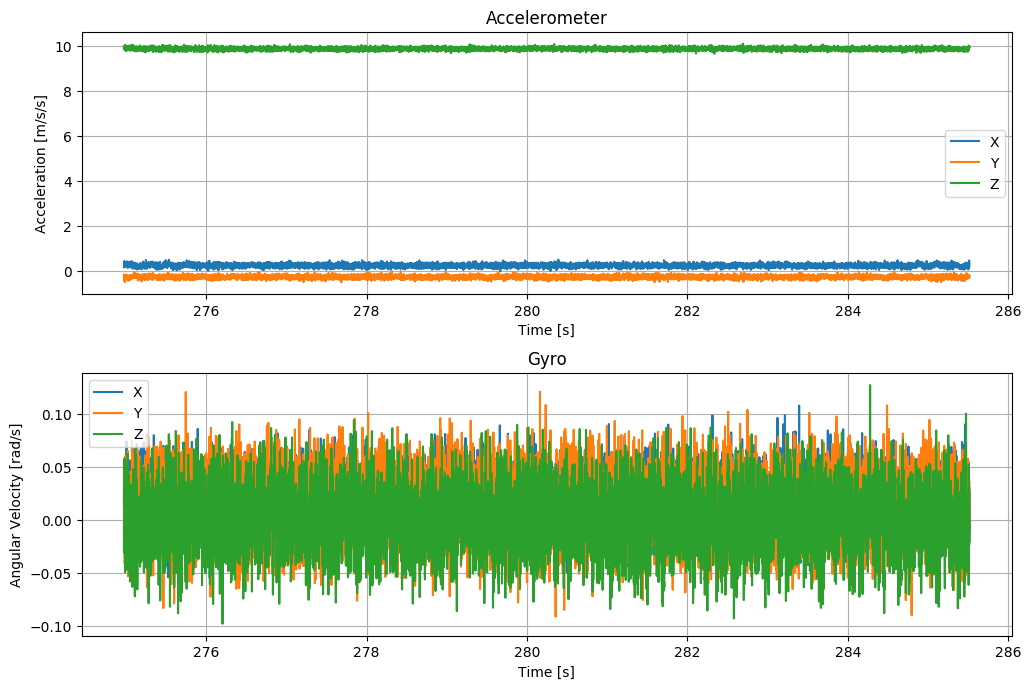

In [5]:
tt.getstats(data)
tt.batch.plot(data)

### Applying an Algorithm Online

In [6]:
lpf = LPF()
Ts = 1./Fs # <-- Note that we may not have access to batch data, so need to specify directly
lpf.set_fc(Ts, 20)
def cb(t, accel, gyro):
    # since our LPF class doesn't care about the size of the data, just stack all measurements into one vector
    stacked = np.hstack((accel,gyro))
    filtered = lpf.apply(stacked)
    
    # extract the relevant elements
    accelf = filtered[0:3]
    gyrof = filtered[3:7]
    
    # return filtered outputs
    return (t, accelf, gyrof)

def plotCb(pw, pdata):
    N = len(pdata)
    pw.plot(np.array(pdata)[0:N,0], np.array(pdata)[0:N,1], pen='y', clear=True)
    pw.plot(np.array(pdata)[0:N,0], np.array(pdata)[0:N,2], pen='r')
    pw.plot(np.array(pdata)[0:N,0], np.array(pdata)[0:N,3], pen='g')

In [7]:
data, dataf = tt.online.process(Fs, cb, plotCb=plotCb, plot_raw=True, seconds=5)

Sample rate: 1000 Hz
Duration:    8.82 seconds
Mean accel:  (0.42, 0.29, 9.75)
std. accel:  (0.92, 1.86, 2.40)
Mean gyro:   (0.01, 0.00, -0.02)
std. gyro:   (0.79, 1.11, 0.57)
Sample rate: 1000 Hz
Duration:    8.82 seconds
Mean accel:  (0.42, 0.29, 9.75)
std. accel:  (0.86, 1.81, 2.29)
Mean gyro:   (0.01, 0.00, -0.02)
std. gyro:   (0.76, 1.08, 0.55)


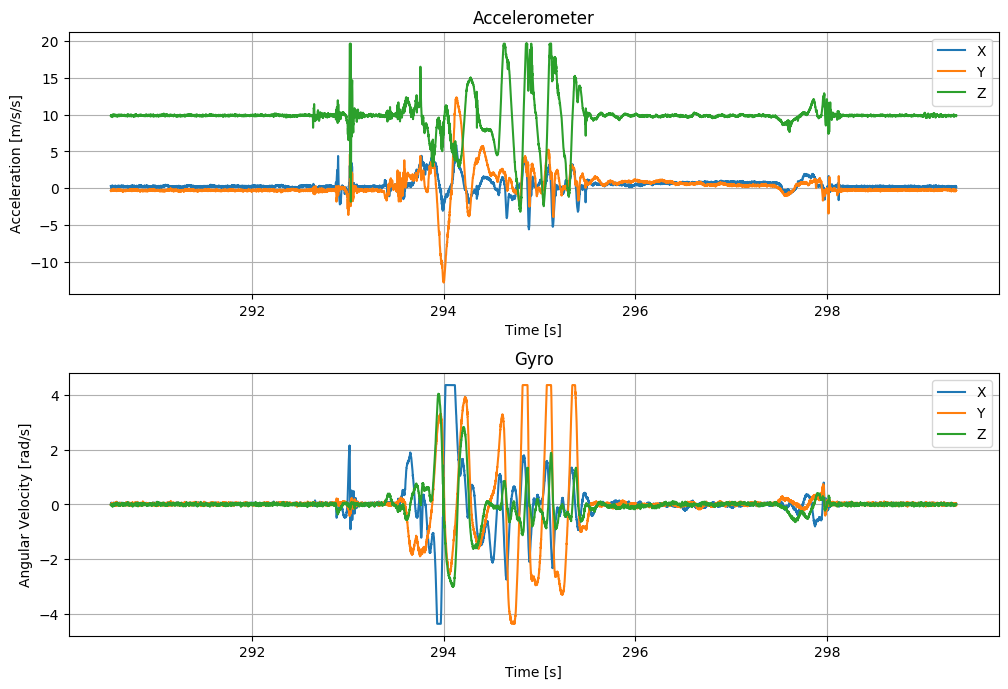

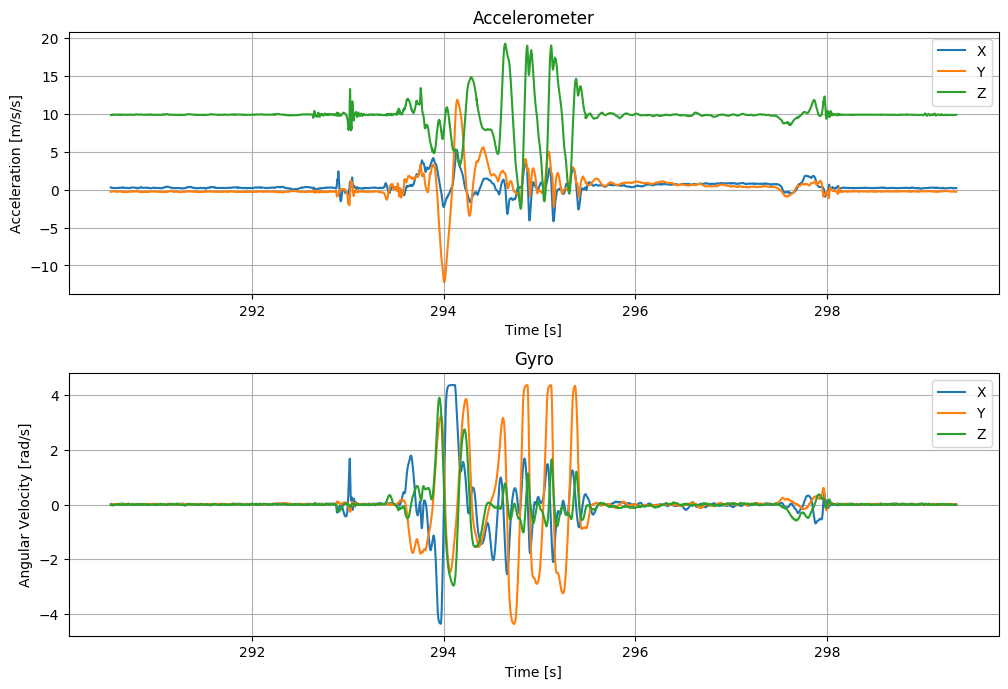

In [9]:
tt.getstats(data)
tt.batch.plot(data)
tt.getstats(dataf)
tt.batch.plot(dataf)